In [1]:
from torch.utils.data import DataLoader

from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn 
import torch

import matplotlib.pyplot as plt
import numpy as np

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <11CA4EBF-5A84-3662-A35A-A039CEE97F5E> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('mps')
print(f"Device selected : {device}")

Device selected : mps


# Load datasets

In [3]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset   = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset    = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Model Network

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3),                nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3),              nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, 3, padding=1),  nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(384, 256, 3, padding=1),  nn.ReLU(),
            nn.Conv2d(256, 256, 1),             nn.ReLU(), nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 1024),                 nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),               nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256)
        x = self.classifier(x)
        return x

# Training

In [5]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [6]:
loss_ = list()
n = len(trainloader)

for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    loss_.append(running_loss / n)
    print(f"{epoch + 1} loss : {running_loss / len(trainloader)}")


1 loss : 1.62560495244183
2 loss : 1.149801015606006
3 loss : 0.9456653640732426
4 loss : 0.8111456942840486
5 loss : 0.7218475711799477
6 loss : 0.6433071188547638
7 loss : 0.5765859524428044
8 loss : 0.5133517255633593
9 loss : 0.47249059307598107
10 loss : 0.43260494632955093
11 loss : 0.39102422222924094
12 loss : 0.36707588960312343
13 loss : 0.334414342054841
14 loss : 0.31710140741122167
15 loss : 0.29673050369492954
16 loss : 0.28125309045066055
17 loss : 0.25292152747594093
18 loss : 0.241461507600666
19 loss : 0.23987165255077608
20 loss : 0.2289778370021706
21 loss : 0.21912545567915864
22 loss : 0.21042670896163618
23 loss : 0.20239745812777785
24 loss : 0.2035479870943921
25 loss : 0.18918521669428134
26 loss : 0.17489287568231232
27 loss : 0.1786136959055415
28 loss : 0.16934072763785082
29 loss : 0.1684284482184191
30 loss : 0.1744749998477611
31 loss : 0.17070896268178878
32 loss : 0.1710695652847559
33 loss : 0.14624298424153873
34 loss : 0.16859375857890352
35 loss : 

# Result Visualization

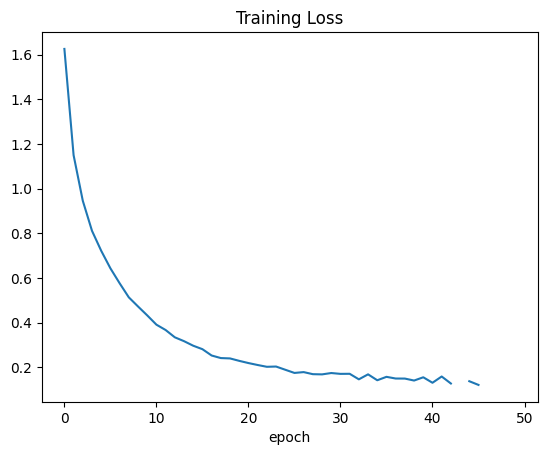

In [7]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

# Model save

In [9]:
PATH = './models/cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

alexnet = AlexNet().to(device)
alexnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
correct, total = 0, 0
with torch.no_grad():
    alexnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Test Accuracy : ",(100 * correct / total), "%")

Test Accuracy :  74.43 %
